In [1]:
import os
import sys
import json
from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

## data load

In [2]:
BASE_DIR = '../mnt/inputs/origin'
TRN_BASE_DIR = '../mnt/inputs/features/train'
TST_BASE_DIR = '../mnt/inputs/features/test'
# BASE_DIR = '../mnt/inputs/features/test'

In [3]:
!ls $BASE_DIR
!ls $TRN_BASE_DIR

data-science-bowl-2019.zip  test.csv	  train2.csv
sample_submission.csv	    train.csv	  train_labels.csv
specs.csv		    train.pkl.gz
specs_w_event_id.csv	    train1.csv
EncodingTitles.pkl  EventCount2.pkl    PrevAssessAccByTitle.pkl  Worldcount.pkl
EventCount.pkl	    KernelBasics2.pkl  SessionTime2.pkl


In [4]:
trn_df = pd.read_pickle(f'{BASE_DIR}/train.pkl.gz')
specs_df = pd.read_csv(f'{BASE_DIR}/specs_w_event_id.csv')
display(trn_df.shape, trn_df.head())

(11341042, 11)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [5]:
trn_labels_df = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
display(trn_labels_df.shape, trn_labels_df.head())

(17690, 7)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [6]:
tst_df = pd.read_csv(f'{BASE_DIR}/test.csv')
tst_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES


In [7]:
sub_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
sub_df.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


## データ構造の理解

In [43]:
tst_df.query('type == "Assessment"').drop_duplicates('game_session').head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
282,7ad3efc6,8b38fc0d2fd315dc,2019-09-11T18:56:11.918Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
867,90d848e0,348d7f09f96af313,2019-09-12T13:52:12.193Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1547,90d848e0,009c890ce6c4f3e3,2019-09-22T21:23:06.296Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1953,7ad3efc6,e8e62de939f916bc,2019-09-22T21:38:58.329Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
2318,5b49460a,ab61cae5e3215355,2019-09-22T21:50:37.983Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Chest Sorter (Assessment),Assessment,CRYSTALCAVES


In [42]:
tst_df.query('game_session == "8b38fc0d2fd315dc"')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
282,7ad3efc6,8b38fc0d2fd315dc,2019-09-11T18:56:11.918Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
283,65a38bf7,8b38fc0d2fd315dc,2019-09-11T18:56:12.019Z,"{""crystals"":[{""id"":""gem07"",""weight"":6},{""id"":""...",00abaee7,2,2020,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
284,795e4a37,8b38fc0d2fd315dc,2019-09-11T18:56:12.030Z,"{""description"":""We've got to balance this scal...",00abaee7,3,3010,58,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
285,5e109ec3,8b38fc0d2fd315dc,2019-09-11T18:56:15.790Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,4,4030,3852,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
286,5c2f29ca,8b38fc0d2fd315dc,2019-09-11T18:56:17.869Z,"{""crystal_id"":""gem07"",""weight"":6,""coordinates""...",00abaee7,5,4020,5968,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
287,828e68f9,8b38fc0d2fd315dc,2019-09-11T18:56:19.084Z,"{""description"":""We've got to balance this scal...",00abaee7,6,3110,7185,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
288,5e109ec3,8b38fc0d2fd315dc,2019-09-11T18:56:19.155Z,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",00abaee7,7,4030,7218,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
289,5c2f29ca,8b38fc0d2fd315dc,2019-09-11T18:56:19.783Z,"{""crystal_id"":""gem08"",""weight"":6,""coordinates""...",00abaee7,8,4020,7885,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
290,acf5c23f,8b38fc0d2fd315dc,2019-09-11T18:56:23.168Z,"{""coordinates"":{""x"":842,""y"":654,""stage_width"":...",00abaee7,9,4070,11252,Cart Balancer (Assessment),Assessment,CRYSTALCAVES
291,acf5c23f,8b38fc0d2fd315dc,2019-09-11T18:56:23.184Z,"{""coordinates"":{""x"":267,""y"":609,""stage_width"":...",00abaee7,10,4070,11252,Cart Balancer (Assessment),Assessment,CRYSTALCAVES


In [45]:
tst_df.query('game_session == "348d7f09f96af313"')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
867,90d848e0,348d7f09f96af313,2019-09-12T13:52:12.193Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [46]:
tst_df.query('game_session == "009c890ce6c4f3e3"')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
1547,90d848e0,009c890ce6c4f3e3,2019-09-22T21:23:06.296Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1548,923afab1,009c890ce6c4f3e3,2019-09-22T21:23:06.641Z,"{""description"":""Put the right sized bucket und...",01242218,2,3010,390,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1549,532a2afb,009c890ce6c4f3e3,2019-09-22T21:23:06.644Z,"{""buckets"":[3,2,1],""target_bucket"":0,""mode"":""p...",01242218,3,2020,390,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1550,3ee399c3,009c890ce6c4f3e3,2019-09-22T21:23:09.263Z,"{""coordinates"":{""x"":510,""y"":758,""stage_width"":...",01242218,4,4070,3007,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1551,37ee8496,009c890ce6c4f3e3,2019-09-22T21:23:10.588Z,"{""bucket"":2,""buckets"":[3,0,1],""coordinates"":{""...",01242218,5,4030,4324,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1552,2dcad279,009c890ce6c4f3e3,2019-09-22T21:23:11.279Z,"{""description"":""Put the right sized bucket und...",01242218,6,3110,5040,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1553,30614231,009c890ce6c4f3e3,2019-09-22T21:23:11.303Z,"{""bucket"":2,""destination"":""middle"",""coordinate...",01242218,7,4020,5057,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1554,37ee8496,009c890ce6c4f3e3,2019-09-22T21:23:12.641Z,"{""bucket"":3,""buckets"":[0,0,1],""coordinates"":{""...",01242218,8,4030,6374,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1555,30614231,009c890ce6c4f3e3,2019-09-22T21:23:12.885Z,"{""bucket"":3,""destination"":""left"",""coordinates""...",01242218,9,4020,6641,Cauldron Filler (Assessment),Assessment,MAGMAPEAK
1556,37ee8496,009c890ce6c4f3e3,2019-09-22T21:23:13.823Z,"{""bucket"":1,""buckets"":[0,0,0],""coordinates"":{""...",01242218,10,4030,7557,Cauldron Filler (Assessment),Assessment,MAGMAPEAK


In [51]:
trn_labels_df.iloc[1:2]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0


In [52]:
trn_df.query('game_session == "77b8ee947eb84b4e"')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2681,f56e0afc,77b8ee947eb84b4e,2019-08-06T05:35:19.167Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Bird Measurer (Assessment),Assessment,TREETOPCITY
2682,ec138c1c,77b8ee947eb84b4e,2019-08-06T05:35:19.174Z,"{""stage_number"":1,""event_count"":2,""game_time"":...",0006a69f,2,2020,0,Bird Measurer (Assessment),Assessment,TREETOPCITY
2683,1375ccb7,77b8ee947eb84b4e,2019-08-06T05:35:19.177Z,"{""description"":""Use the caterpillars to measur...",0006a69f,3,3010,0,Bird Measurer (Assessment),Assessment,TREETOPCITY
2684,bdf49a58,77b8ee947eb84b4e,2019-08-06T05:35:23.654Z,"{""description"":""Use the caterpillars to measur...",0006a69f,4,3110,4536,Bird Measurer (Assessment),Assessment,TREETOPCITY
2685,51102b85,77b8ee947eb84b4e,2019-08-06T05:35:24.263Z,"{""hat"":0,""caterpillar"":""left"",""coordinates"":{""...",0006a69f,5,4030,5119,Bird Measurer (Assessment),Assessment,TREETOPCITY
...,...,...,...,...,...,...,...,...,...,...,...
2763,51102b85,77b8ee947eb84b4e,2019-08-06T05:36:47.990Z,"{""hat"":0,""caterpillar"":""right"",""coordinates"":{...",0006a69f,83,4030,88857,Bird Measurer (Assessment),Assessment,TREETOPCITY
2764,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:36:48.351Z,"{""height"":6,""bird_height"":5,""correct"":false,""c...",0006a69f,84,4025,89224,Bird Measurer (Assessment),Assessment,TREETOPCITY
2765,17113b36,77b8ee947eb84b4e,2019-08-06T05:36:49.155Z,"{""correct"":false,""caterpillars"":[5,8,6],""event...",0006a69f,85,4110,90032,Bird Measurer (Assessment),Assessment,TREETOPCITY
2766,ad2fc29c,77b8ee947eb84b4e,2019-08-06T05:36:49.157Z,"{""description"":""Uh oh. This caterpillar is too...",0006a69f,86,3020,90032,Bird Measurer (Assessment),Assessment,TREETOPCITY


In [7]:
a = trn_df.query('game_session == "77b8ee947eb84b4e"')
a[a.event_data.str.contains('correct')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
2686,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:26.351Z,"{""height"":11,""bird_height"":4,""correct"":false,""...",0006a69f,6,4025,7220,Bird Measurer (Assessment),Assessment,TREETOPCITY
2688,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:28.466Z,"{""height"":11,""bird_height"":8,""correct"":false,""...",0006a69f,8,4025,9337,Bird Measurer (Assessment),Assessment,TREETOPCITY
2690,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:30.999Z,"{""height"":11,""bird_height"":5,""correct"":false,""...",0006a69f,10,4025,11870,Bird Measurer (Assessment),Assessment,TREETOPCITY
2693,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:32.555Z,"{""height"":11,""bird_height"":5,""correct"":false,""...",0006a69f,13,4025,13428,Bird Measurer (Assessment),Assessment,TREETOPCITY
2696,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:33.520Z,"{""height"":11,""bird_height"":5,""correct"":false,""...",0006a69f,16,4025,14395,Bird Measurer (Assessment),Assessment,TREETOPCITY
2698,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:37.002Z,"{""height"":1,""bird_height"":8,""correct"":false,""c...",0006a69f,18,4025,17878,Bird Measurer (Assessment),Assessment,TREETOPCITY
2700,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:39.328Z,"{""height"":11,""bird_height"":8,""correct"":false,""...",0006a69f,20,4025,20203,Bird Measurer (Assessment),Assessment,TREETOPCITY
2702,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:41.984Z,"{""height"":5,""bird_height"":8,""correct"":false,""c...",0006a69f,22,4025,22853,Bird Measurer (Assessment),Assessment,TREETOPCITY
2704,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:44.799Z,"{""height"":7,""bird_height"":5,""correct"":false,""c...",0006a69f,24,4025,25679,Bird Measurer (Assessment),Assessment,TREETOPCITY
2706,4a4c3d21,77b8ee947eb84b4e,2019-08-06T05:35:48.604Z,"{""height"":8,""bird_height"":8,""correct"":true,""ca...",0006a69f,26,4025,29471,Bird Measurer (Assessment),Assessment,TREETOPCITY


In [22]:
specs_df.query('event_code == 4100')

,event_id,info,args,event_code
370,d122731b,This event occurs when the player on the done ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0
371,a5e9da97,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0
372,392e14df,This event occurs when the player on the done ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0
373,14de4c5d,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0
374,25fa8af4,This event occurs when the player on the done ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0
375,070a5291,This event occurs when the player on the done ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0
376,93b353f2,This event occurs when the player on the done ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4100.0


In [21]:
specs_df.query('event_id == "17113b36"')['info'].iloc[0]

'This event occurs when the player on the done button to submit a solution. It contains information about the length of caterpillars dragged and the correctness of the action. This event is used to calculate accuracy and to diagnose player strategies and understanding.'

In [57]:
target_trn_df = trn_df[((trn_df.event_code == 4100)
                         & (trn_df.title != "Bird Measurer (Assessment)"))
               | ((trn_df.event_code == 4110)
                 & (trn_df.title == "Bird Measurer (Assessment)"))
            ]
target_trn_df.query('type == "Assessment"').installation_id.nunique()

3614

In [28]:
target_tst_df = tst_df[((tst_df.event_code == 4100)
                         & (tst_df.title != "Bird Measurer (Assessment)"))
               | ((tst_df.event_code == 4110)
                 & (tst_df.title == "Bird Measurer (Assessment)"))
            ]
target_tst_df.query('type == "Assessment"').installation_id.nunique()

557

In [29]:
sub_df.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [33]:
df = pd.read_pickle(f'{TST_BASE_DIR}/KernelBasics2.pkl')
display(df.shape, df.head())

(1000, 62)

,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),...,prev_acc_gr_-99,prev_acc_gr_0,prev_acc_gr_1,prev_acc_gr_2,prev_acc_gr_3,prev_cumnum_c,prev_cumnum_inc,prev_num_corrects,prev_num_incorrects,type
25,0,0,1960,0,0,0,0,33,30,0,...,1,0,0,0,0,1,0,0,0,Assessment
57,0,123,64,0,82,349,96,74,15,36,...,1,0,0,0,0,4,7,0,0,Assessment
8,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Assessment
13,0,0,77,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Assessment
24,0,0,610,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Assessment


In [8]:
tst_df.installation_id.nunique()

1000

In [11]:
tst_df.event_data.value_counts()

{"event_code": 2000, "event_count": 1}                                                                                                                                                                                                                                                      15253
{"version":"1.0","event_count":1,"game_time":0,"event_code":2000}                                                                                                                                                                                                                            7286
{"version":"1.0","round":0,"event_count":1,"game_time":0,"event_code":2000}                                                                                                                                                                                                                  4536
{"version":"1","round":0,"event_count":1,"game_time":0,"event_code":2000}                                                         

In [16]:
tst_df["gs_max_time"] = tst_df.groupby("game_session")["timestamp"].transform('max')

pd.pivot_table(tst_df, index=["gs_max_time", "game_session", "type"],
               columns="title",
               values="game_time",
               aggfunc="max").fillna(0)#.sort_values('game_session')

,,title,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),...,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!
gs_max_time,game_session,type,,,,,,,,,,,,,,,,,,,,,
2019-07-24T00:04:25.361Z,52639fb59747ca49,Clip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-24T00:05:00.917Z,197f8bb606461cdc,Clip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-24T00:05:44.404Z,ea7ea89e7ce39690,Clip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-24T00:07:10.848Z,a46069b40e05632a,Activity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5760.0,0.0
2019-07-24T00:07:33.154Z,ff18375c4bae193b,Clip,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-14T20:55:22.650Z,5ca3aff929c45966,Activity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17857175.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14T20:58:11.884Z,5dca1caeb434e559,Activity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-14T20:58:44.121Z,9d593e7daaf53852,Activity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
tst_df.sort_values('game_session').head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,gs_max_time
317389,beb0a7b9,000326e9d4516dd0,2019-10-02T20:03:21.453Z,"{""description"":""Go lower!"",""identifier"":""Dot_G...",48166507,255,3010,173016,Fireworks (Activity),Activity,TREETOPCITY,2019-10-02T20:03:58.224Z
317198,884228c8,000326e9d4516dd0,2019-10-02T20:01:14.726Z,"{""coordinates"":{""x"":934,""y"":672,""stage_width"":...",48166507,64,4070,46290,Fireworks (Activity),Activity,TREETOPCITY,2019-10-02T20:03:58.224Z
317327,02a42007,000326e9d4516dd0,2019-10-02T20:02:39.677Z,"{""rocket"":5,""coordinates"":{""x"":508,""y"":606,""st...",48166507,193,4030,131229,Fireworks (Activity),Activity,TREETOPCITY,2019-10-02T20:03:58.224Z
317328,e694a35b,000326e9d4516dd0,2019-10-02T20:02:40.773Z,"{""rocket"":5,""height"":2,""duration"":1100,""coordi...",48166507,194,4020,132329,Fireworks (Activity),Activity,TREETOPCITY,2019-10-02T20:03:58.224Z
317329,beb0a7b9,000326e9d4516dd0,2019-10-02T20:02:42.535Z,"{""description"":""Go lower!"",""identifier"":""Dot_G...",48166507,195,3010,134096,Fireworks (Activity),Activity,TREETOPCITY,2019-10-02T20:03:58.224Z


In [17]:
tst_df["gs_max_time"] = tst_df.groupby("game_session")["timestamp"].transform('max')

pd.pivot_table(tst_df, index=["game_session"],
               columns="title",
               values="game_time",
               aggfunc="max").fillna(0)#.sort_values('game_session')

title,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),...,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!
game_session,,,,,,,,,,,,,,,,,,,,,
000326e9d4516dd0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0003a9881ca100aa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00094643cae0f886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000ccfa39b7568d7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001352e3c9cde9dd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff27a9fe743447e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff358902c51ffc5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fff5ac15aeb06eb2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,519404.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
_idx = (((tst_df.event_code == 4100)
                    & (tst_df.type == "Assessment")
                    & (tst_df.title != "Bird Measurer (Assessment)"))
                   | ((tst_df.event_code == 4110)
                      & (tst_df.type == "Assessment")
                      & (tst_df.title == "Bird Measurer (Assessment)"))).values

In [27]:
tst_df[_idx].installation_id.nunique()

557

In [31]:
tst_df.drop_duplicates('installation_id').head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,gs_max_time
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-10T16:50:24.910Z
868,27253bdc,8f8b93e30590f263,2019-09-22T20:58:41.078Z,"{""event_code"": 2000, ""event_count"": 1}",01242218,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-22T20:58:41.078Z
3587,27253bdc,d1706431c69d0f17,2019-08-02T23:24:03.145Z,"{""event_code"": 2000, ""event_count"": 1}",017c5718,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-02T23:24:03.145Z
3737,27253bdc,d1ab3259ce39c0e3,2019-07-25T06:32:05.394Z,"{""event_code"": 2000, ""event_count"": 1}",01a44906,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-07-25T06:32:05.394Z
3971,27253bdc,13000ef509c619aa,2019-08-15T15:09:17.690Z,"{""event_code"": 2000, ""event_count"": 1}",01bc6cb6,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-15T15:09:17.690Z


In [33]:
tst_df.query('installation_id == "01bc6cb6"').sort_values('timestamp').tail()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,gs_max_time
4918,a7640a16,f3cf31016ae2c824,2019-09-06T18:05:11.423Z,"{""coordinates"":{""x"":508,""y"":425,""stage_width"":...",01bc6cb6,127,4070,152581,Happy Camel,Game,CRYSTALCAVES,2019-09-06T18:05:14.403Z
4919,a7640a16,f3cf31016ae2c824,2019-09-06T18:05:11.944Z,"{""coordinates"":{""x"":818,""y"":436,""stage_width"":...",01bc6cb6,128,4070,153098,Happy Camel,Game,CRYSTALCAVES,2019-09-06T18:05:14.403Z
4920,a7640a16,f3cf31016ae2c824,2019-09-06T18:05:12.753Z,"{""coordinates"":{""x"":857,""y"":455,""stage_width"":...",01bc6cb6,129,4070,153914,Happy Camel,Game,CRYSTALCAVES,2019-09-06T18:05:14.403Z
4921,a7640a16,f3cf31016ae2c824,2019-09-06T18:05:14.403Z,"{""coordinates"":{""x"":744,""y"":121,""stage_width"":...",01bc6cb6,130,4070,155568,Happy Camel,Game,CRYSTALCAVES,2019-09-06T18:05:14.403Z
4922,7ad3efc6,46e8bbed71df7520,2019-09-06T18:05:26.197Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01bc6cb6,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,2019-09-06T18:05:26.197Z


In [60]:
tst_df[tst_df.event_data.str.contains('true')]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,gs_max_time
27,4ef8cdd3,a022c3f60ba547e7,2019-09-10T16:54:34.359Z,"{""weight"":3,""correct"":true,""scale_weight"":3,""s...",00abaee7,24,4020,22264,Chow Time,Game,CRYSTALCAVES,2019-09-10T16:56:27.894Z
37,4ef8cdd3,a022c3f60ba547e7,2019-09-10T16:54:42.779Z,"{""weight"":3,""correct"":true,""scale_weight"":3,""s...",00abaee7,34,4020,30683,Chow Time,Game,CRYSTALCAVES,2019-09-10T16:56:27.894Z
55,4ef8cdd3,a022c3f60ba547e7,2019-09-10T16:54:54.561Z,"{""weight"":3,""correct"":true,""scale_weight"":3,""s...",00abaee7,52,4020,42467,Chow Time,Game,CRYSTALCAVES,2019-09-10T16:56:27.894Z
93,4ef8cdd3,a022c3f60ba547e7,2019-09-10T16:55:21.898Z,"{""weight"":1,""correct"":true,""scale_weight"":1,""s...",00abaee7,90,4020,69803,Chow Time,Game,CRYSTALCAVES,2019-09-10T16:56:27.894Z
105,4ef8cdd3,a022c3f60ba547e7,2019-09-10T16:55:37.098Z,"{""weight"":3,""correct"":true,""scale_weight"":3,""s...",00abaee7,102,4020,85005,Chow Time,Game,CRYSTALCAVES,2019-09-10T16:56:27.894Z
...,...,...,...,...,...,...,...,...,...,...,...,...
1156352,392e14df,70336ec581799feb,2019-09-10T18:56:26.743Z,"{""buckets"":[0,0,0],""correct"":true,""buckets_pla...",ffe00ca8,27,4100,21068,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-09-10T18:56:37.640Z
1156399,5f0eb72c,46ff9d3ad2be09f2,2019-09-28T21:20:31.407Z,"{""height"":2,""destination"":""left"",""stumps"":[2,0...",ffe774cc,29,4020,22514,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-28T21:20:45.499Z
1156401,5f0eb72c,46ff9d3ad2be09f2,2019-09-28T21:20:33.783Z,"{""height"":4,""destination"":""right"",""stumps"":[2,...",ffe774cc,31,4020,24883,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-28T21:20:45.499Z
1156404,5f0eb72c,46ff9d3ad2be09f2,2019-09-28T21:20:36.299Z,"{""height"":3,""destination"":""middle"",""stumps"":[2...",ffe774cc,34,4020,27386,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-09-28T21:20:45.499Z


In [58]:
tst_df.type.value_counts()

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

In [59]:
tst_df.world.value_counts()

MAGMAPEAK       511291
TREETOPCITY     332295
CRYSTALCAVES    311387
NONE              1441
Name: world, dtype: int64

In [57]:
# tst_df.head(1000).groupby('game_session').agg({'game_time': ['skew', lambda x: x.kurt()]})
tst_df.head(1000).groupby('game_session').agg(
    {
        'game_time': {'skew': 'skew', 'kurt': lambda x: x.kurt()},
        'timestamp': ['max']
    }
)

game_time                            timestamp
                      skew       kurt                       max
game_session                                                   
09a603baebcc2052 -0.060525  -1.194911  2019-09-12T13:42:59.372Z
0ea9ecc81a565215       NaN        NaN  2019-09-10T16:50:24.910Z
1003218031f43998 -1.502841   3.556559  2019-09-22T21:06:25.539Z
18c82207b2e63482       NaN        NaN  2019-09-11T13:44:33.549Z
1c203986674d7d9b       NaN        NaN  2019-09-10T16:56:39.003Z
237c4e2190a4b5fe       NaN        NaN  2019-09-11T16:14:14.819Z
2841aa0233220ac0  3.642278  11.600854  2019-09-11T13:44:15.540Z
2c3592f7677f33cf       NaN        NaN  2019-09-11T14:44:53.535Z
348d7f09f96af313       NaN        NaN  2019-09-12T13:52:12.193Z
3b845db6d1d108b5       NaN        NaN  2019-09-10T16:57:24.641Z
41591f66b833b47c  0.172641  -1.242731  2019-09-11T13:46:25.154Z
6ecafbf9e7451a99 -1.505417   1.325779  2019-09-12T13:45:12.842Z
704e6c1a66c26810       NaN        NaN  2019-09-12T13:40:37.266Z
74ce1888faaea83a  0.592653  -0.636693  2019-09-12T13:47:56.142Z
74ee9fa728ed47ec  0.192909  -1.403748  2019-09-12T13:44:31.558Z
7e516ace50e7fe67       NaN        NaN  2019-09-10T16:53:12.825Z
7ed86c6b72e725e2       NaN        NaN  2019-09-10T16:51:51.805Z
7f4ff05e14cea4ea       NaN        NaN  2019-09-22T20:59:09.640Z
81b84937f7021692 -0.000299  -1.736502  2019-09-11T18:59:10.431Z
8b38fc0d2fd315dc  0.069719  -0.719531  2019-09-11T18:56:41.937Z
8f8b93e30590f263       NaN        NaN  2019-09-22T20:58:41.078Z
95bc2e9a5c91e643       NaN        NaN  2019-09-11T18:55:26.733Z
a022c3f60ba547e7  0.115980  -1.208629  2019-09-10T16:56:27.894Z
a09b503c4b8d7000       NaN        NaN  2019-09-22T20:59:42.371Z
adc1bb4aabbaf129       NaN        NaN  2019-09-11T16:14:26.048Z
b3529e1187ceaf8f       NaN        NaN  2019-09-11T14:44:34.801Z
c1ea43d8b8261d27       NaN        NaN  2019-09-10T16:50:55.503Z
c58423edbb934d93       NaN        NaN  2019-09-10T16:57:00.851Z
ee2200d38a57537b -0.279390  -1.222891  2019-09-12T13:51:47.878Z
ffd20705b83b25bc -0.087266  -1.430341  2019-09-12T13:45:33.821Z
ffec6761763be29e  0.413599  -1.711634  2019-09-22T21:05:05.523Z

In [37]:
specs_df.query('event_code == 4070')['info'].iloc[0]

'This event occurs when the player clicks on something that isn’t covered elsewhere. It can be useful in determining if there are attractive distractions (things the player think should do something, but don’t) in the game, or diagnosing players who are having mechanical difficulties (near misses).'

In [36]:
specs_df.query('event_id == "a7640a16"')['info'].iloc[0]

"This event occurs when the player clicks on something that isn't covered elsewhere. It can be useful in determining if there are attractive distractions (things the player think should do something but don't) in the game or diagnosing players who are having mechanical difficulties (near misses)."

In [39]:
specs_df.args.value_counts()

[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\n'audio' || 'animation' || 'other'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]                                                                                                                                                                                                                                                                              

In [49]:
import itertools
', '.join(np.unique(list(itertools.chain.from_iterable(specs_df.args.apply(lambda x: [y['name'] for y in json.loads(x)])))))

'animal, animals, bird_height, bottle, bottles, bowl_id, bowls, bucket, buckets, buckets_placed, bug, bug_length, buglength, castles_placed, caterpillar, caterpillars, cauldron, chests, cloud, cloud_size, container_type, containers, coordinates, correct, crystal_id, crystals, current_containers, description, destination, diet, dinosaur, dinosaur_count, dinosaur_weight, dinosaurs, dinosaurs_placed, distance, duration, dwell_time, end_position, event_code, event_count, exit_type, filled, flower, flowers, game_time, gate, group, growth, has_toy, has_water, hat, hats, hats_placed, height, holding_shell, hole_position, holes, house, houses, identifier, item_type, jar, jar_filled, launched, layout, left, level, location, max_position, media_type, misses, mode, molds, movie_id, nest, object, object_type, options, pillars, position, previous_jars, prompt, resources, right, rocket, round, round_number, round_prompt, round_target, sand, scale_contents, scale_weight, scale_weights, session_durati

In [79]:
import itertools
specs_df.args.apply(lambda x: tuple([y['name'] for y in json.loads(x)])).value_counts()

(game_time, round, description, identifier, media_type, duration, event_count, event_code)                        28
(game_time, round, description, identifier, media_type, total_duration, event_count, event_code)                  28
(game_time, description, identifier, media_type, duration, event_count, event_code)                               22
(game_time, description, identifier, media_type, total_duration, event_count, event_code)                         22
(game_time, round, coordinates, event_count, event_code)                                                          20
                                                                                                                  ..
(game_time, round, weight, source, resources, coordinates, event_count, event_code)                                1
(game_time, round, distance, event_count, event_code)                                                              1
(game_time, round, shells, holes, holding_shell, has_water, even

In [63]:
specs_df[specs_df['args'].str.contains('event_code')].args.iloc[0]

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"version","type":"string","info":"identifier of the current version of the game being played"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

In [64]:
specs_df[specs_df['args'].str.contains('event_code')]

,event_id,info,args,event_code
0,9b23e8ee,The start game event is triggered at the very ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",2000.0
1,6d90d394,The start game event is triggered at the very ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",2000.0
2,3bfd1a65,The start game event is triggered at the very ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",2000.0
3,7d093bf9,The start game event is triggered at the very ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",2000.0
4,48349b14,The start game event is triggered at the very ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",2000.0
...,...,...,...,...
381,85de926c,This event occurs when the player finishes dra...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",4235.0
382,a6d66e51,This event occurs when the player fills the po...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",5000.0
383,71e712d8,This event occurs when the dinosaurs finish dr...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",5010.0
384,b738d3d3,The exit game event is triggered when the game...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill...",NaN


In [72]:
for i, j in tst_df.groupby(['installation_id', 'game_session']):
    display(j)
    break

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,gs_max_time
447,9b23e8ee,09a603baebcc2052,2019-09-12T13:41:30.964Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",00abaee7,1,2000,0,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
448,736f9581,09a603baebcc2052,2019-09-12T13:41:31.161Z,"{""layout"":{""row1"":[""empty"",""right"",""empty""],""r...",00abaee7,3,2020,67,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
449,7ab78247,09a603baebcc2052,2019-09-12T13:41:31.161Z,"{""description"":""Use the rocks to weigh down th...",00abaee7,2,3010,67,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
450,b80e5e84,09a603baebcc2052,2019-09-12T13:41:37.342Z,"{""description"":""Use the rocks to weigh down th...",00abaee7,4,3110,6395,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
451,9e34ea74,09a603baebcc2052,2019-09-12T13:41:37.796Z,"{""coordinates"":{""x"":763,""y"":385,""stage_width"":...",00abaee7,5,4070,6828,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
...,...,...,...,...,...,...,...,...,...,...,...,...
503,7ab78247,09a603baebcc2052,2019-09-12T13:42:55.075Z,"{""description"":""Incoming!"",""identifier"":""Buddy...",00abaee7,57,3010,84101,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
504,b80e5e84,09a603baebcc2052,2019-09-12T13:42:56.318Z,"{""description"":""Incoming!"",""identifier"":""Buddy...",00abaee7,58,3110,85371,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
505,461eace6,09a603baebcc2052,2019-09-12T13:42:57.230Z,"{""gate"":{""row"":1,""column"":2,""side"":""left""},""la...",00abaee7,59,4020,86257,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z
506,4c2ec19f,09a603baebcc2052,2019-09-12T13:42:57.780Z,"{""nest"":4,""layout"":{""row1"":[""empty"",""left"",""em...",00abaee7,60,4025,86833,Egg Dropper (Activity),Activity,CRYSTALCAVES,2019-09-12T13:42:59.372Z


In [74]:
tst_df.groupby(['installation_id', 'game_session'])

In [68]:
trn_labels_df.set_index('game_session').shift(1)

,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
game_session,,,,,,
6bdf9623adc94d89,NaN,NaN,NaN,NaN,NaN,NaN
77b8ee947eb84b4e,0006a69f,Mushroom Sorter (Assessment),1.0,0.0,1.000000,3.0
901acc108f55a5a1,0006a69f,Bird Measurer (Assessment),0.0,11.0,0.000000,0.0
9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1.0,0.0,1.000000,3.0
a9ef3ecb3d1acc6a,0006a69f,Mushroom Sorter (Assessment),1.0,1.0,0.500000,2.0
...,...,...,...,...,...,...
c996482b11d149dd,ffc90c32,Mushroom Sorter (Assessment),1.0,2.0,0.333333,1.0
b05a02b52d5c1f4c,ffc90c32,Bird Measurer (Assessment),1.0,0.0,1.000000,3.0
5448d652309a6324,ffd2871d,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0


## feature importance 見てみる

In [36]:
imp_df = pd.read_csv('../mnt/importances/e008.csv')
display(imp_df.shape, imp_df.head())

(4605, 3)

,feature,importance,fold
0,12 Monkeys,0.000000,0
1,Air Show,362.017689,0
2,All Star Sorting,1100.404541,0
3,Balancing Act,0.000000,0
4,Bird Measurer (Assessment),235.946411,0


In [48]:
a = imp_df.groupby('feature').agg({'importance': ['std', 'mean']})
a.columns = [f'{col[0]}_{col[1]}' for col in a.columns]
a.sort_values('importance_mean', inplace=True, ascending=False)
a = a.reset_index()
a

,feature,importance_std,importance_mean
0,title_enc,5350.532729,203967.337688
1,cum_accuracy,1907.869410,38724.366099
2,cum_acc_cum_Chest Sorter (Assessment),811.523215,12468.848642
3,cum_acc_cum_Bird Measurer (Assessment),826.941053,11328.638048
4,cum_acc_cum_Mushroom Sorter (Assessment),1113.834177,10187.786781
...,...,...,...
916,f005_event_id_ratio_5e812b27,0.000000,0.000000
917,f005_event_id_ratio_5e3ea25a,0.000000,0.000000
918,f005_event_id_ratio_5e109ec3,0.000000,0.000000
919,f005_event_id_ratio_5de79a6a,0.000000,0.000000


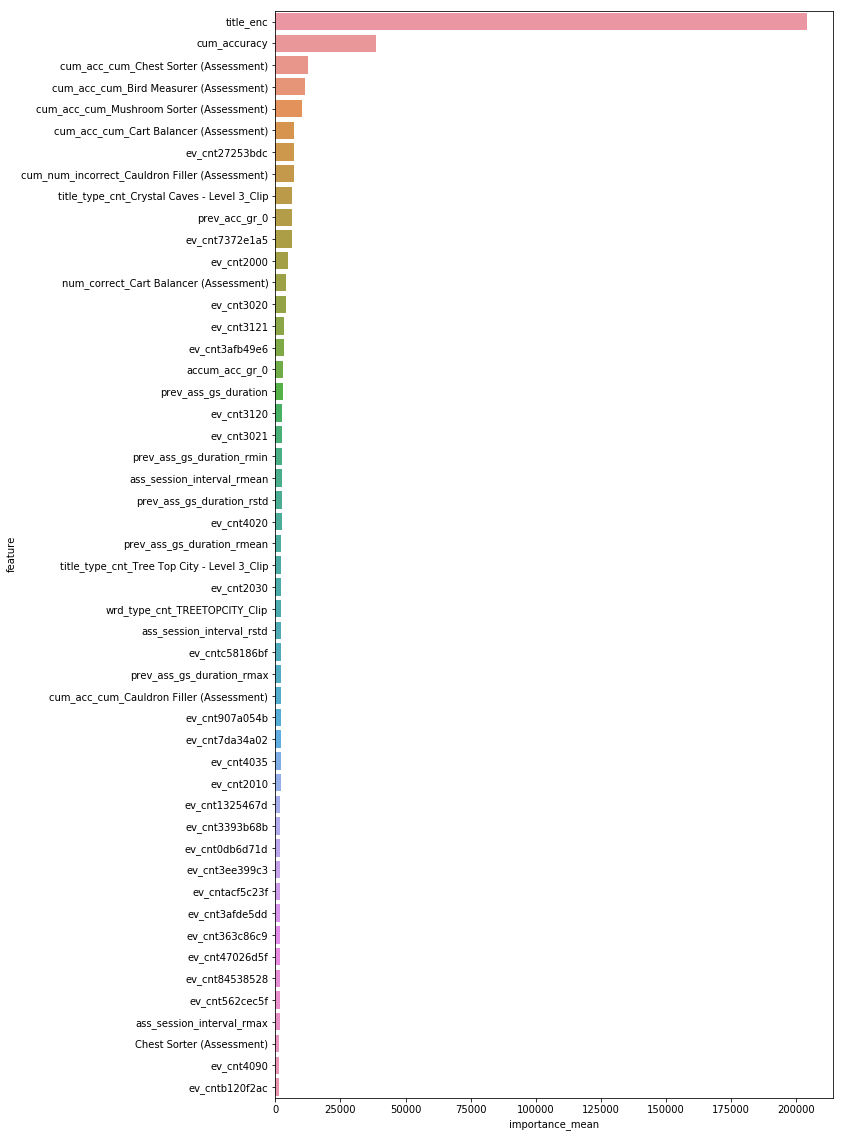

In [49]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance_mean', y='feature', data=a,  order=a.feature.head(50))

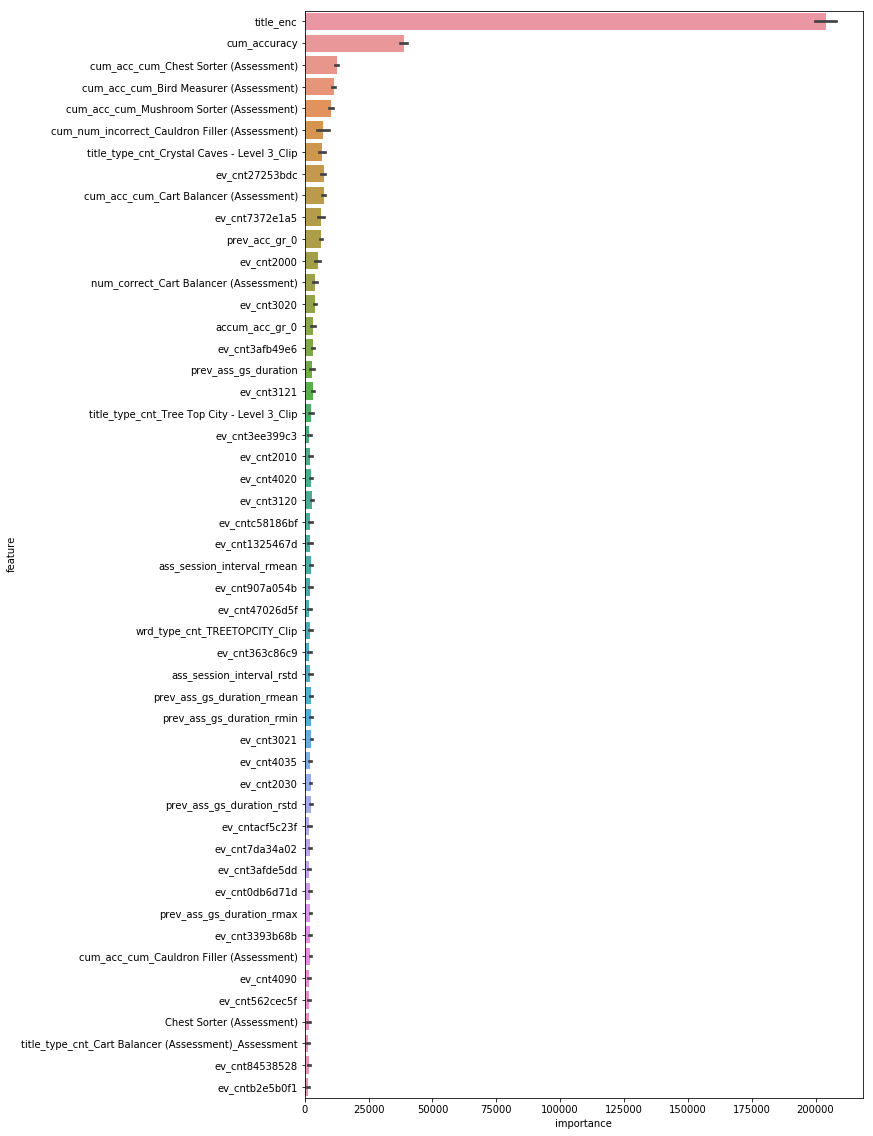

In [56]:
plt.figure(figsize=(10, 20))
sns.barplot(x='importance', y='feature', data=imp_df,  order=imp_df.sort_values('importance', ascending=False).drop_duplicates('feature').feature.head(50))

In [50]:
trn_df.title.value_counts()

Chow Time                        1150974
Sandcastle Builder (Activity)    1034332
Scrub-A-Dub                      1016837
Bottle Filler (Activity)         1004068
Fireworks (Activity)              535030
All Star Sorting                  509344
Dino Drink                        492916
Bubble Bath                       458972
Crystals Rule                     453852
Bug Measurer (Activity)           446430
Chicken Balancer (Activity)       443156
Dino Dive                         427655
Pan Balance                       384857
Watering Hole (Activity)          369270
Flower Waterer (Activity)         356034
Happy Camel                       311543
Air Show                          306239
Leaf Leader                       282104
Egg Dropper (Activity)            248408
Mushroom Sorter (Assessment)      199595
Chest Sorter (Assessment)         190318
Bird Measurer (Assessment)        190164
Cauldron Filler (Assessment)      181925
Cart Balancer (Assessment)        163343
Welcome to Lost 

In [58]:
target_trn_df.title.value_counts()

Pan Balance                     28388
Bird Measurer (Assessment)      11158
Chest Sorter (Assessment)        9967
Air Show                         8509
Cauldron Filler (Assessment)     7468
Cart Balancer (Assessment)       6697
Mushroom Sorter (Assessment)     6259
Name: title, dtype: int64

In [66]:
pd.crosstab(trn_labels_df.title, trn_labels_df.accuracy_group, margins=True)

accuracy_group,0,1,2,3,All
title,,,,,
Bird Measurer (Assessment),886,778,389,693,2746
Cart Balancer (Assessment),576,353,470,2752,4151
Cauldron Filler (Assessment),421,459,630,2545,4055
Chest Sorter (Assessment),1752,466,256,507,2981
Mushroom Sorter (Assessment),594,355,460,2348,3757
All,4229,2411,2205,8845,17690


## 思いついている feature 達
 - 一つ前の session についての features
 - session の頭に map を開いたか否か

In [15]:
trn_df.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [16]:
trn_df.query('game_session == "45bb1e1b6b50c07b"')

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE


In [20]:
cross_df = pd.crosstab(trn_df.event_code, trn_df.event_id)
cross_df

event_id,003cd2ee,0086365d,00c73085,01ca3a3c,022b4259,02a42007,0330ab6a,0413e89d,04df9b66,05ad839b,...,f56e0afc,f5b8c21a,f6947f54,f71c4741,f7e47413,f806dc10,f93fc684,fbaf3456,fcfdffb6,fd20ea40
event_code,,,,,,,,,,,,,,,,,,,,,
2000,0,0,0,0,0,0,0,0,0,0,...,3113,0,0,0,0,0,0,0,0,0
2010,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13327,0,0,0,0
2025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2030,0,0,11175,0,0,0,0,0,0,0,...,0,5530,3275,0,0,0,0,0,0,0
2035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2060,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# 各 event_id はある特定の event_code についてのみしか起きない
(cross_df == 0).sum(axis=0).value_counts()

41    384
dtype: int64

In [24]:
specs_df = specs_df.merge(trn_df[['event_id', 'event_code']].drop_duplicates(['event_id', 'event_code']).reset_index(drop=True), on='event_id', how='left')

In [28]:
specs_df.sort_values('event_code').to_csv(f'{BASE_DIR}/specs_w_event_id.csv', index=False)

#### trn_df の Assessment の直前の id_code 見てみる

In [34]:
def res_just_before_row(df):
    df = df.sort_values('timestamp')
    return df[(df.type == 'Assessment').shift(-1).fillna(False).values]

res = []
for i, grp_df in tqdm(trn_df[trn_df.game_session.isin(trn_labels_df.game_session.values)].groupby('game_session')):
    res.append(res_just_before_row(grp_df))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [37]:
grp_df

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
8349559,3bfd1a65,fff641eaf483ae2b,2019-10-11T19:29:35.513Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",bac91c32,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349560,db02c830,fff641eaf483ae2b,2019-10-11T19:29:35.635Z,"{""event_count"":2,""game_time"":106,""event_code"":...",bac91c32,2,2025,106,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349561,a1e4395d,fff641eaf483ae2b,2019-10-11T19:29:35.644Z,"{""description"":""Pull three mushrooms out of th...",bac91c32,3,3010,106,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349562,a52b92d5,fff641eaf483ae2b,2019-10-11T19:29:39.470Z,"{""description"":""Pull three mushrooms out of th...",bac91c32,4,3110,4016,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349563,a1e4395d,fff641eaf483ae2b,2019-10-11T19:29:39.474Z,"{""description"":""To pick a mushroom, pull it ou...",bac91c32,5,3010,4016,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349564,a52b92d5,fff641eaf483ae2b,2019-10-11T19:29:42.181Z,"{""description"":""To pick a mushroom, pull it ou...",bac91c32,6,3110,6733,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349565,28ed704e,fff641eaf483ae2b,2019-10-11T19:29:47.500Z,"{""height"":4,""coordinates"":{""x"":310,""y"":530,""st...",bac91c32,7,4025,12050,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349566,9d29771f,fff641eaf483ae2b,2019-10-11T19:29:47.506Z,"{""description"":""That's one!"",""identifier"":""Dot...",bac91c32,8,3021,12050,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349567,c74f40cd,fff641eaf483ae2b,2019-10-11T19:29:48.147Z,"{""description"":""That's one!"",""identifier"":""Dot...",bac91c32,9,3121,12700,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
8349568,28ed704e,fff641eaf483ae2b,2019-10-11T19:29:48.872Z,"{""height"":1,""coordinates"":{""x"":191,""y"":521,""st...",bac91c32,10,4025,13400,Mushroom Sorter (Assessment),Assessment,TREETOPCITY


In [35]:
res[0]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
81944,3bfd1a65,00097cda27afb726,2019-09-15T16:36:41.450Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01bdd720,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81945,db02c830,00097cda27afb726,2019-09-15T16:36:41.555Z,"{""event_count"":2,""game_time"":0,""event_code"":2025}",01bdd720,2,2025,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81946,a1e4395d,00097cda27afb726,2019-09-15T16:36:41.565Z,"{""description"":""Pull three mushrooms out of th...",01bdd720,3,3010,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81947,7da34a02,00097cda27afb726,2019-09-15T16:36:45.384Z,"{""coordinates"":{""x"":609,""y"":560,""stage_width"":...",01bdd720,4,4070,3942,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81948,28ed704e,00097cda27afb726,2019-09-15T16:36:45.388Z,"{""height"":1,""coordinates"":{""x"":191,""y"":522,""st...",01bdd720,5,4025,3942,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81949,a52b92d5,00097cda27afb726,2019-09-15T16:36:45.391Z,"{""description"":""Pull three mushrooms out of th...",01bdd720,6,3110,3942,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81950,9d29771f,00097cda27afb726,2019-09-15T16:36:45.394Z,"{""description"":""That's one!"",""identifier"":""Dot...",01bdd720,7,3021,3942,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81951,c74f40cd,00097cda27afb726,2019-09-15T16:36:46.032Z,"{""description"":""That's one!"",""identifier"":""Dot...",01bdd720,8,3121,4625,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81952,7da34a02,00097cda27afb726,2019-09-15T16:36:46.145Z,"{""coordinates"":{""x"":191,""y"":512,""stage_width"":...",01bdd720,9,4070,4725,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
81953,28ed704e,00097cda27afb726,2019-09-15T16:36:47.019Z,"{""height"":2,""coordinates"":{""x"":516,""y"":493,""st...",01bdd720,10,4025,5608,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
